# HW1 Forward and Inverse Kinematics
Ting-Wei Hsu (twhsu3)

In [137]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

# QP solver
from qpsolvers import solve_qp

## Universal Robots UR10
The Universal Robots UR10 is a 6-joint collaborative robot arm. It is engineered and manufactured by Universal Robots (UR). The UR10s are mainly used in manufacturing and logistic industries. In particular, automovie companies employ UR10s on their vehicle assembly lines for high-precision tasks, and logistic companies use UR10s for automated picking and packing. The price ranges from $45,000 to $60,000 USD.

In [138]:
# Load model
robot = load_robot_description(
    'ur10_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 6 joints.


Print a list of all frames.

In [139]:
print('Print all frames\n')
for frame in robot.model.frames:
    print(f' {frame.name}')

Print all frames

 universe
 world
 world_joint
 base_link
 base_link-base_fixed_joint
 base
 shoulder_pan_joint
 shoulder_link
 shoulder_lift_joint
 upper_arm_link
 elbow_joint
 forearm_link
 wrist_1_joint
 wrist_1_link
 wrist_2_joint
 wrist_2_link
 wrist_3_joint
 wrist_3_link
 ee_fixed_joint
 ee_link
 wrist_3_link-tool0_fixed_joint
 tool0


In [140]:
print('Print joint translations\n')

for i in range(1, robot.model.njoints):
    joint_name = robot.model.names[i]
    
    # Translation from Parent Joint -> This Joint
    translation = robot.model.jointPlacements[i].translation
    print(f"{translation}")
    
target_frames = ["ee_link"]

for frame in robot.model.frames:
    if frame.name in target_frames:
        # frame.placement is the transform from the Parent Joint (Wrist 3) -> This Frame
        translation = frame.placement.translation
        print(f"{translation}")


Print joint translations

[0.     0.     0.1273]
[0.       0.220941 0.      ]
[ 0.     -0.1719  0.612 ]
[0.     0.     0.5723]
[0.     0.1149 0.    ]
[0.     0.     0.1157]
[0.     0.0922 0.    ]


Display the robot in browser

In [141]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
# - All frames
frames_to_show = [
    'base_link',
    'shoulder_link',
    'upper_arm_link',
    'forearm_link',
    'wrist_1_link',
    'wrist_2_link',
    'wrist_3_link',
    'ee_link',
]

for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

# Get and show the neutral configuration (most likely all zeros)
theta = pin.neutral(robot.model)
print(f'{theta = }')

# Forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or theta)
pin.forwardKinematics(robot.model, robot.data, theta)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(theta)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
theta = array([0., 0., 0., 0., 0., 0.])


Create sliders that allow us to change the configuration.

In [ ]:
# Callback function that receives all 6 slider values
def on_slider_change(change):
    theta = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(theta)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create 6 sliders
sliders = []
for i in range(6):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Define some useful functions

In [ ]:
def to_skew(w):
    w_skew = np.zeros([3,3])
    w_skew[0,1] = -w[2]
    w_skew[1,0] = w[2]
    w_skew[0,2] = w[1]
    w_skew[2,0] = -w[1]
    w_skew[1,2] = -w[0]
    w_skew[2,1] = w[0]
    return w_skew

def from_skew(w_skew):
    return np.array([w_skew[2, 1], w_skew[0, 2], w_skew[1, 0]])

def hat(V):
    V_hat = np.zeros([4,4])
    V_hat[0:3, 0:3] = to_skew(V[0:3])
    V_hat[0:3,3] = V[3:6]
    return V_hat

def vee(V_hat):
    return np.concatenate([from_skew(V_hat[0:3, 0:3]), V_hat[0:3, 3]])

def adjoint(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R, np.zeros((3, 3))],
                     [to_skew(p) @ R, R]])

def adjoint_inv(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    return np.block([[R.T, np.zeros((3, 3))],
                     [-R.T @ to_skew(p), R.T]])

## Forward Kinematics 

The pose of the end-effector with respect to the base frame (spatial frame) is denoted by $T(\theta)\in SE(3)$, where $\theta\in\mathbb{R}^6$ consists of all joint angles. The pose can be expressed as 
$$
T(\theta) = \begin{bmatrix}
R & p \\
0_{1 \times 3} & 1
\end{bmatrix},
$$
where $R\in SO(3)$ is the orientation matrix, and $p\in\mathbb{R}^{3\times 1}$ is the position vector. 
We also denote $M\coloneqq T(0)$ when all joint angles are set to zeros. 
Using product of exponential (Chapter 4 of Modern Robotics by Lynch and Park), we have

$$T(\theta)=e^{\widehat{S}_1\theta_1} e^{\widehat{S}_2\theta_2}\cdots e^{\widehat{S}_6\theta_6}M,$$
where $\widehat{S}_i \in se(3)$ (and $S_i\in\mathbb{R}^6$) denotes the screw axis in the spatial frame (i.e., spatial twist) corresponding to each joint. In particular, 
$$
S_i = \begin{bmatrix}
\omega_i \\
v_i
\end{bmatrix} \in\mathbb{R}^6
$$
and 
$$
\widehat{S}_i =
\begin{bmatrix}
\widehat{\omega}_i & v_i \\
0 & 0
\end{bmatrix} \in se(3)
$$
Because all the six joints of UR10 are revolute joints, the angular velocity $\omega_i\in\mathbb{R}^3$ is a unit vector aligned with the revolute axis of the $i$-th joint expressed in the spatial frame, and the linear velocity $v_i =-\omega_i \times q_i $, where $q_i$ is any point on the revolute axis expressed in the spatial frame.  

Below, we define a function to compute forward kinematics using the method discussed above. 

In [ ]:
# M := T(0) is fixed 
M = np.array([[0., 1., 0., 0.612+0.5723],
              [1., 0., 0., 0.220941-0.1719+0.1149+0.0922],
              [0., 0., -1., 0.1273-0.1157],
              [0., 0., 0., 1.]])

In [ ]:
def forward_kinematics(theta, M):

    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    q = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]

    T = M
    for w_i, q_i, theta_i in reversed(list(zip(w, q, theta))):
        S = np.concatenate((w_i, -to_skew(w_i) @ q_i)) # spatial twist
        T = expm(hat(S) * theta_i) @ T

    return T

Compare our forward kinematic solution to the one given by pinocchio.

In [ ]:
# Sample a configuration at random
theta = pin.randomConfiguration(robot.model)
 
# Forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(theta)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Get pose of last link (pinocchio)
T_pin = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous

# Get pose of last link (by hand)
T_ours = forward_kinematics(theta, M)

# Print the two solutions
print('PINOCCHIO')
print(T_pin)
print('')
print('OURS')
print(T_ours)

# Check that the two solutions are the same
assert(np.allclose(T_pin, T_ours))

PINOCCHIO
[[-0.15887987 -0.84983835 -0.50252559 -0.01503695]
 [ 0.69374632 -0.45825112  0.55562753 -0.10171626]
 [-0.7024765  -0.26034726  0.6623791   0.26331988]
 [ 0.          0.          0.          1.        ]]

OURS
[[-0.15887987 -0.84983835 -0.50252559 -0.01503695]
 [ 0.69374632 -0.45825112  0.55562753 -0.10171626]
 [-0.7024765  -0.26034726  0.6623791   0.26331988]
 [-0.          0.          0.          1.        ]]


Compare the computation time.

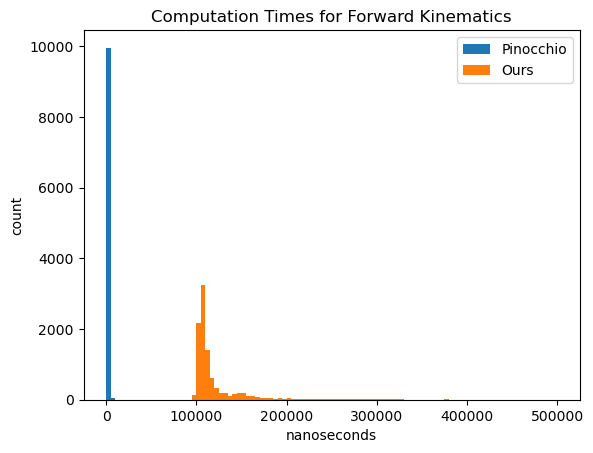

Mean computation times
 Pinocchio:      952 ns
 Ours:   125941 ns


In [ ]:
# Arrays in which to store computation times
t_pin = []
t_ours = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    # Sample a configuration
    theta = pin.randomConfiguration(robot.model)

    # Measure the time of computing forward kinematics with pinocchio (in nanoseconds)
    start_time = time.perf_counter_ns()
    pin.framesForwardKinematics(robot.model, robot.data, theta)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time of computing forward kinematics using our function (in nanoseconds)
    start_time = time.perf_counter_ns()
    T = forward_kinematics(theta, M)
    end_time = time.perf_counter_ns()
    t_ours.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_ours, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Forward Kinematics')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_ours):8.0f} ns')

## Forward Velocity Kinematics

The spatial twist of the end-effector is given by
$$
\widehat{\mathcal{V}}_s = \dot{T}T^{-1},
$$
where
$$
\dot{T}
=
\left(\frac{d}{dt} e^{\widehat{S}_1 \theta_1}\right)
e^{\widehat{S}_2 \theta_2}
\cdots
e^{\widehat{S}_n \theta_n} M
+
e^{\widehat{S}_1 \theta_1}
\left(\frac{d}{dt} e^{\widehat{S}_2 \theta_2}\right)
\cdots
e^{\widehat{S}_n \theta_n} M
+ \cdots
$$
$$
=
\widehat{S}_1 \dot{\theta}_1
e^{\widehat{S}_1 \theta_1}
\cdots
e^{\widehat{S}_n \theta_n} M
+
e^{\widehat{S}_1 \theta_1}
\widehat{S}_2 \dot{\theta}_2
e^{\widehat{S}_2 \theta_2}
\cdots
e^{\widehat{S}_n \theta_n} M
+ \cdots .
$$

Also,
$$
T^{-1}
=
M^{-1}
e^{-\widehat{S}_n \theta_n}
\cdots
e^{-\widehat{S}_1 \theta_1}.
$$

Therefore,
$$
\widehat{\mathcal{V}}_s = \dot{T}T^{-1}
=
\widehat{S}_1 \dot{\theta}_1
+
e^{\widehat{S}_1 \theta_1}
\widehat{S}_2
e^{-\widehat{S}_1 \theta_1}
\dot{\theta}_2
+
e^{\widehat{S}_1 \theta_1}
e^{\widehat{S}_2 \theta_2}
\widehat{S}_3
e^{-\widehat{S}_2 \theta_2}
e^{-\widehat{S}_1 \theta_1}
\dot{\theta}_3
+ \cdots .
$$

The above can also be expressed in vector form by means of the adjoint mapping:
$$
\mathcal{V}_s
=
S_1 \dot{\theta}_1
+
\mathrm{Ad}_{e^{\widehat{S}_1 \theta_1}}(S_2)
\dot{\theta}_2
+
\mathrm{Ad}_{e^{\widehat{S}_1 \theta_1}
e^{\widehat{S}_2 \theta_2}}(S_3)
\dot{\theta}_3
+ \cdots .
$$

This can be expressed in matrix form,
$$
\mathcal{V}_s
=
\begin{bmatrix}
S_1 & S'_2 \cdots & S'_n
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}_1 \\
\vdots \\
\dot{\theta}_n
\end{bmatrix}
\coloneqq
J_s(\theta)\dot{\theta}.
$$
where $S'_i \coloneqq \mathrm{Ad}_{e^{\widehat{S}_1 \theta_1} \cdots
e^{\widehat{S}_{i-1} \theta_{i-1}}}(S_i)$ for $i=2,\cdots n$. 


Similarly, we can derive the forward velocity kinematics in the body frame. 
First, note that the end-effector pose can also be expressed by product of exponentials using body twitsts, such as
$$
T(\theta) =
M
e^{\widehat{B}_1 \theta_1}
e^{\widehat{B}_2 \theta_2}
\cdots
e^{\widehat{B}_n \theta_n},
$$
where $\widehat{B}_i \in se(3)$ (and $B_i\in\mathbb{R}^6$) is the screw axis in the body frame (i.e., body twist) of each joint. 

The body twist of the end-effector is given by
$$
\widehat{\mathcal{V}}_b = T^{-1}\dot{T},
$$
where 
$$
\begin{align*}
\dot{T} &=
M e^{\widehat{B}_1 \theta_1}
\cdots
e^{\widehat{B}_{n-1} \theta_{n-1}}
\left( \frac{d}{dt} e^{\widehat{B}_n \theta_n} \right)
+ M e^{\widehat{B}_1 \theta_1}
\cdots
\left( \frac{d}{dt} e^{\widehat{B}_{n-1} \theta_{n-1}} \right)
e^{\widehat{B}_n \theta_n}
+ \cdots \\
&=
M e^{\widehat{B}_1 \theta_1}
\cdots
e^{\widehat{B}_n \theta_n}
\widehat{B}_n \dot{\theta}_n
+ M e^{\widehat{B}_1 \theta_1}
\cdots
e^{\widehat{B}_{n-1} \theta_{n-1}}
\widehat{B}_{n-1}
e^{\widehat{B}_n \theta_n}
\dot{\theta}_{n-1}
+ \cdots
+ M e^{\widehat{B}_1 \theta_1} \widehat{B}_1
e^{\widehat{B}_2 \theta_2}
\cdots
e^{\widehat{B}_n \theta_n}
\dot{\theta}_1 
\end{align*}
$$
and 
$$
T^{-1} =
e^{-\widehat{B}_n \theta_n}
\cdots
e^{-\widehat{B}_1 \theta_1}
M^{-1}.
$$

Therefore,
$$
\widehat{\mathcal{V}}_b = T^{-1}\dot{T} =
\widehat{B}_n \dot{\theta}_n
+
e^{-\widehat{B}_n \theta_n}
\widehat{B}_{n-1}
e^{\widehat{B}_n \theta_n}
\dot{\theta}_{n-1}
+ \cdots +
e^{-\widehat{B}_n \theta_n}
\cdots
e^{-\widehat{B}_2 \theta_2}
\widehat{B}_1
e^{\widehat{B}_2 \theta_2}
\cdots
e^{\widehat{B}_n \theta_n}
\dot{\theta}_1 .
$$

Converting to vector form, we have
$$
\begin{align*}
\mathcal{V}_b &=
B_n \dot{\theta}_n
+
\mathrm{Ad}_{e^{-\widehat{B}_n \theta_n}}(B_{n-1}) \dot{\theta}_{n-1}
+ \cdots
+
\mathrm{Ad}_{e^{-\widehat{B}_n \theta_n} \cdots e^{-\widehat{B}_2 \theta_2}}(B_1)\dot{\theta}_1 \\
&= \begin{bmatrix}
B'_1 & \cdots & B'_{n-1} & B_n
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}_1 \\
\vdots \\
\dot{\theta}_n
\end{bmatrix} \\
&\coloneqq J_b(\theta)\dot{\theta},
\end{align*}
$$
where $B'_i \coloneqq \mathrm{Ad}_{e^{-\widehat{B}_n \theta_n} \cdots e^{-\widehat{B}_{i+1} \theta_{i+1}}}(B_i)$ for $i=1,2,\cdots n-1$.

Below, we define functions that compute the spatial Jacobian $J_s(\theta)$ and body Jacobians $J_b(\theta)$ using the method mentioned above.

In [ ]:
def Jacobian_space(theta):
    
    # axis of each joint in spatial frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in spatial frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize spatial Jacobian as all zeros
    J_s = np.zeros((6, len(theta)))

    # Compute all the other columns of the spatial Jacobian
    for i in range(len(theta)):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        
        theta_i = theta[i]
        
        if i == 0:
            J_s[:, i] = s_i
            e_train = expm(hat(s_i) * theta_i)
        else:
            J_s[:, i] = adjoint(e_train) @ s_i # e_train = e^1 @ e^2 @ ... @ e^(i-1)
            e_train = e_train @ expm(hat(s_i) * theta_i)

    # Return the spatial Jacobian
    return J_s

def Jacobian_body(theta, M):
    
    # axis of each joint in spatial frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in spatial frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize spatial Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    # Compute all the other columns of the spatial Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i)) # spatial screw axis
        b_i = adjoint_inv(M) @ s_i # convert the spatial screw axis to the end-effector body frame
        
        theta_i = theta[i]

        if i == len(theta) - 1:
            J_b[:, i] = b_i
            e_train =  expm(-hat(b_i) * theta_i)
        else:
            J_b[:, i] = adjoint(e_train) @ b_i # e_train = e^i @ e^(i+1) @ ... @ e^n
            e_train =  e_train @ expm(-hat(b_i) * theta_i)
        
    # Return the spatial Jacobian
    return J_b

def Jacobian_body_2(theta, M):
    # Alternative way to compute the body Jacobian
    
    # axis of each joint in spatial frame
    w = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., -1.],
         [0., 1., 0.]]
    
    # a point on the axis in spatial frame
    p = [[0., 0., 0.1273],
         [0., 0.220941, 0.1273],
         [0.612, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273],
         [0.612+0.5723, 0.220941-0.1719+0.1149, 0.1273-0.1157]]
    
    # Initialize spatial Jacobian as all zeros
    J_b = np.zeros((6, len(theta)))

    e_train = M

    # Compute all the other columns of the spatial Jacobian
    for i in reversed(range(len(theta))):
        w_i = w[i]
        p_i = p[i]
        s_i = np.concatenate((w_i, -to_skew(w_i) @ p_i))
        
        theta_i = theta[i]
        
        e_train =  expm(hat(s_i) * theta_i) @ e_train
        J_b[:, i] = adjoint_inv(e_train) @ s_i # e_train = e^i @ e^(i+1) @ ... @ e^n @ M

    # Return the spatial Jacobian
    return J_b

Check that our spatial Jacobian matches what is computed by Pinocchio.

In [ ]:
# Sample a configuration
theta = pin.randomConfiguration(robot.model)

# Compute forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta)
pin.updateFramePlacements(robot.model, robot.data)

# Compute the spatial Jacobian with Pinocchio
pin.computeJointJacobians(robot.model, robot.data)
# - Get the spatial Jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_s_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
# - Reorder the spatial Jacobian to be consistent with an assumption that twists are (w, v)
J_s_pin = np.vstack((J_s_pin_vw[3:, :], J_s_pin_vw[:3, :]))

# Compute the spatial Jacobian using our function
J_s_ours = Jacobian_space(theta)

# Check if the two results are the same
print('Spatical Jacobian by Pinocchio:')
print(J_s_pin)
print('Spatical Jacobian by Ours:')
print(J_s_ours)
assert(np.allclose(J_s_pin, J_s_ours))


Spatical Jacobian by Pinocchio:
[[ 0.         -0.04715386 -0.04715386 -0.04715386 -0.12873896  0.98518366]
 [ 0.          0.99888764  0.99888764  0.99888764 -0.0060773  -0.11504366]
 [ 1.          0.          0.          0.          0.99165989  0.12719317]
 [ 0.         -0.1271584   0.17544216 -0.38963729  0.1439477   0.07614442]
 [ 0.         -0.00600269  0.00828199 -0.01839336  0.39840095  0.55676251]
 [ 0.          0.         -0.53176391 -0.44515603  0.0211291  -0.08620145]]
Spatical Jacobian by Ours:
[[ 0.         -0.04715386 -0.04715386 -0.04715386 -0.12873896  0.98518366]
 [ 0.          0.99888764  0.99888764  0.99888764 -0.0060773  -0.11504366]
 [ 1.          0.          0.          0.          0.99165989  0.12719317]
 [ 0.         -0.1271584   0.17544216 -0.38963729  0.1439477   0.07614442]
 [ 0.         -0.00600269  0.00828199 -0.01839336  0.39840095  0.55676251]
 [ 0.          0.         -0.53176391 -0.44515603  0.0211291  -0.08620145]]


Compare computation times of the spatial Jacobians

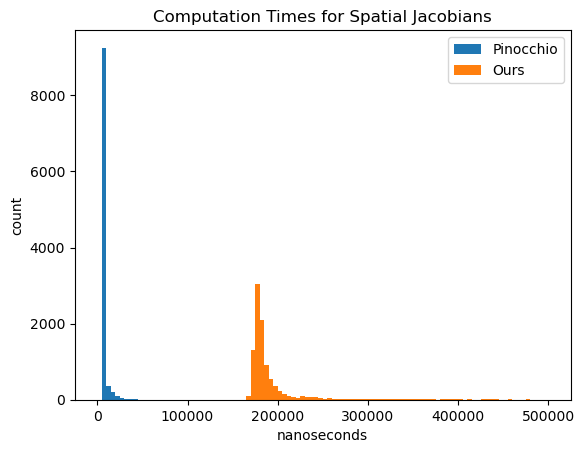

Mean computation times
 Pinocchio:     7609 ns
 Ours:   199599 ns


In [ ]:
# Arrays in which to store computation times
t_pin = []
t_ours = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    theta = pin.randomConfiguration(robot.model)
    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)

    # Measure the time to compute spatial Jacobian by Pinocchio
    start_time = time.perf_counter_ns()
    pin.computeJointJacobians(robot.model, robot.data)
    J_s_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
    J_s_pin = np.vstack((J_s_pin_vw[3:, :], J_s_pin_vw[:3, :]))
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to compute spatial Jacobian by our implementation
    start_time = time.perf_counter_ns()
    J_s_ours = Jacobian_space(theta)
    end_time = time.perf_counter_ns()
    t_ours.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_ours, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Spatial Jacobians')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_ours):8.0f} ns')

Check that our body Jacobian matches what is computed by Pinocchio.

In [ ]:
# Sample a configuration
theta = pin.randomConfiguration(robot.model)

# Compute forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta)
pin.updateFramePlacements(robot.model, robot.data)


# Compute the body Jacobian with Pinocchio
pin.computeJointJacobians(robot.model, robot.data)
# - Get the body jacobian <-- WARNING - Pinocchio assumes twists are (v, w) and not (w, v)
J_b_pin_vw = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL)
# - Reorder the body jacobian to be consistent with an assumption that twists are (w, v)
J_b_pin = np.vstack((J_b_pin_vw[3:, :], J_b_pin_vw[:3, :]))

# Compute the body Jacobian using our function
J_b_ours = Jacobian_body(theta, M)
J_b_ours_2 = Jacobian_body_2(theta, M)

# Check if the two results are the same
print('Body Jacobian by Pinocchio:')
print(J_b_pin)
print('Body Jacobian by Ours:')
print(J_b_ours)
#print(J_b_ours_2)
assert(np.allclose(J_b_pin, J_b_ours))
assert(np.allclose(J_b_pin, J_b_ours_2))


Body Jacobian by Pinocchio:
[[ 0.77655554  0.09434598  0.09434598  0.09434598 -0.          1.        ]
 [ 0.13273455  0.94203631  0.94203631  0.94203631  0.32341531  0.        ]
 [-0.6159083   0.3219727   0.3219727   0.3219727  -0.94625712  0.        ]
 [ 0.08779214  0.63479992  0.02553483 -0.11518392  0.          0.        ]
 [-0.25042758 -0.20579001 -0.15196033  0.04001507 -0.08724491  0.        ]
 [ 0.05672124  0.41609377  0.43712726 -0.0833254  -0.02981889  0.        ]]
Body Jacobian by Ours:
[[ 0.77655554  0.09434598  0.09434598  0.09434598  0.          1.        ]
 [ 0.13273455  0.94203631  0.94203631  0.94203631  0.32341531  0.        ]
 [-0.6159083   0.3219727   0.3219727   0.3219727  -0.94625712  0.        ]
 [ 0.08779214  0.63479992  0.02553483 -0.11518392  0.          0.        ]
 [-0.25042758 -0.20579001 -0.15196033  0.04001507 -0.08724491  0.        ]
 [ 0.05672124  0.41609377  0.43712726 -0.0833254  -0.02981889  0.        ]]


There are three common ways to describe the motion of the end-effector: as a spatial twist (i.e., spatial velocity in the spatial frame), as a body twist (i.e., spatial velocity in the body frame), or as a tuple of linear velocity and angular velocity (both of the end-effector frame with respect to the base frame in the coordinates of the base frame). Below, we show that we can compute all three of them both with your forward velocity kinematics solution and with Pinocchio.

The derivation for first two expressions (i.e., the spatial twist $\widehat{\mathcal{V}}_s$ and body twist $\widehat{\mathcal{V}}_b$) have been discussed above. In Pinocchio, they are computed by calling ```pin.getFrameVelocity``` with ```pin.ReferenceFrame.WORLD``` and ```pin.ReferenceFrame.LOCAL```, respectively, as the coordinates. 

The third expression can be computed in Pinicchio by calling ```pin.getFrameVelocity``` with ```pin.ReferenceFrame.LOCAL_WORLD_ALIGNED```. 
This frame is fixed on the end-efector and has the same origin as the body frame ```pin.ReferenceFrame.LOCAL```, but its axes are aligned with the spatial frame ```pin.ReferenceFrame.WORLD```.
We will denote the twist of this frame as $\widehat{\mathcal{V}}_a$.
The relationship between $\widehat{\mathcal{V}}_a$ and $\widehat{\mathcal{V}}_b$ is given by
$$
\mathcal{V}_a =  \mathrm{Ad}_{T_{b/a}} \mathcal{V}_b,
$$
where 
$$
T_{b/a} = \begin{bmatrix}
R & 0_{3\times 1} \\
0_{1 \times 3} & 1
\end{bmatrix}
$$
and thus 
$$
\mathrm{Ad}_{T_{b/a}} = \begin{bmatrix}
R & 0_{3\times 3} \\
0_{3 \times 3} & R
\end{bmatrix}.
$$

Below, we will compute the twists of all three frames: ```pin.ReferenceFrame.WORLD```, ```pin.ReferenceFrame.LOCAL```, and ```pin.ReferenceFrame.LOCAL_WORLD_ALIGNED``` using Pinicchio's ```pin.getFrameVelocity``` function. 
We will also compute these quantities using our code, which yields the same results as Pinicchio's.

In [ ]:
# Pick a random configuration and random joint velocity
theta = pin.randomConfiguration(robot.model)
theta_dot = np.random.randn(robot.nv)

pin.forwardKinematics(robot.model, robot.data, theta, theta_dot)
pin.updateFramePlacements(robot.model, robot.data)

# Compute the end-effector twists and using Pinocchio in 3 different reference frames
V_s_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
omega_s_pin, v_s_pin = V_s_pin.angular, V_s_pin.linear

V_b_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL)
omega_b_pin, v_b_pin = V_b_pin.angular, V_b_pin.linear

V_a_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
omega_a_pin, v_a_pin = V_a_pin.angular, V_a_pin.linear

# Our implementation
J_s = Jacobian_space(theta)
V_s_ours = J_s @ theta_dot
omega_s_ours, v_s_ours = V_s_ours[:3], V_s_ours[3:]
assert(np.allclose(omega_s_ours, omega_s_pin))
assert(np.allclose(v_s_ours, v_s_pin))

J_b = Jacobian_body(theta, M)
V_b_ours = J_b @ theta_dot
omega_b_ours, v_b_ours = V_b_ours[:3], V_b_ours[3:]
assert(np.allclose(omega_b_ours, omega_b_pin))
assert(np.allclose(v_b_ours, v_b_pin))

T_ours = forward_kinematics(theta, M)
R_ours = T_ours[0:3, 0:3]
omega_a_ours, v_a_ours = R_ours @ omega_b_ours, R_ours @ v_b_ours # equivalent to applying the adjoint transformation
assert(np.allclose(omega_a_ours, omega_a_pin))
assert(np.allclose(v_a_ours, v_a_pin))

print("End-effector twist in the world (spatial) frame: Pinocchio vs. Ours")
print(f'    omega_s = {omega_s_pin} vs. {omega_s_ours}')
print(f'    v_s     = {v_s_pin} vs. {v_s_ours}')

print("End-effector twist in the body frame: Pinocchio vs. Ours")
print(f'    omega_b = {omega_b_pin} vs. {omega_b_ours}')
print(f'    v_b     = {v_b_pin} vs. {v_b_ours}')

print("End-effector twist in the world-local-aligned frame: Pinocchio vs. Ours")
print(f'    omega_b = {omega_a_pin} vs. {omega_a_ours}')
print(f'    v_b     = {v_a_pin} vs. {v_a_ours}')


End-effector twist in the world (spatial) frame: Pinocchio vs. Ours
    omega_s = [-1.47768618 -0.89100326  2.35952297] vs. [-1.47768618 -0.89100326  2.35952297]
    v_s     = [ 0.20268407 -0.43045999 -1.14942127] vs. [ 0.20268407 -0.43045999 -1.14942127]
End-effector twist in the body frame: Pinocchio vs. Ours
    omega_b = [ 1.69550575  0.14314356 -2.37688074] vs. [ 1.69550575  0.14314356 -2.37688074]
    v_b     = [-0.276747   -0.95314469  0.85085692] vs. [-0.276747   -0.95314469  0.85085692]
End-effector twist in the world-local-aligned frame: Pinocchio vs. Ours
    omega_b = [-1.47768618 -0.89100326  2.35952297] vs. [-1.47768618 -0.89100326  2.35952297]
    v_b     = [-0.17795571  0.96895308 -0.85935609] vs. [-0.17795571  0.96895308 -0.85935609]


Compare the computation times of the forward velocity kinematics

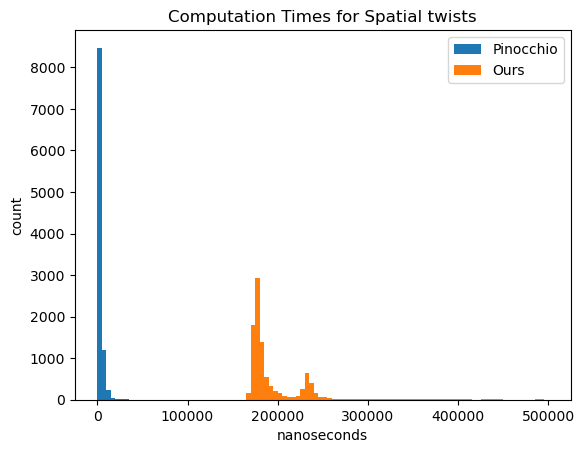

Mean computation times
 Pinocchio:     4012 ns
 Ours:   202798 ns


In [ ]:
# Arrays in which to store computation times
t_pin = []
t_ours = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    theta = pin.randomConfiguration(robot.model)
    theta_dot = np.random.randn(robot.nv)
    pin.forwardKinematics(robot.model, robot.data, theta, theta_dot)
    pin.updateFramePlacements(robot.model, robot.data)

    # Measure the time to compute the spatial twist with Pinocchio
    start_time = time.perf_counter_ns()
    pin.computeJointJacobians(robot.model, robot.data)
    V_s_pin = pin.getFrameVelocity(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.ReferenceFrame.WORLD)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to compute spatial twist by our implementation
    start_time = time.perf_counter_ns()
    J_s = Jacobian_space(theta)
    V_s_ours = J_s @ theta_dot
    end_time = time.perf_counter_ns()
    t_ours.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='Pinocchio')
plt.hist(t_ours, bins=np.linspace(0, 500000, 101), label='Ours')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation Times for Spatial twists')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Pinocchio: {np.mean(t_pin):8.0f} ns')
print(f' Ours: {np.mean(t_ours):8.0f} ns')

## Inverse Kinematics

We define the inverse kinematics as an optimization problem, given by
$$\min_{\theta} \frac{1}{2} \|r(\theta)\|^2 = \min_{\theta} \frac{1}{2} \|(\text{log} (T^{-1}(\theta) T_d) )^\vee\|^2 $$
where $r$ is the error, $T(\theta)\in SE(3)$ is the pose of the end-effector as a function of the joint angles $\theta$, and $T_d\in SE(3)$ is the desired pose of the end-effector.


Set up inverse kinematics problem.

In [ ]:
# Choose a desired pose
T_D = np.array([[1., 0., 0., 0.3],
                  [0., 1., 0., 0.4],
                  [0., 0., 1., 0.5],
                  [0., 0., 0., 1.]])

# Show desired pose in the browser window
meshcat_shapes.frame(vis.viewer['frames/' + 'desired_pose'], opacity=1.0, axis_length=0.2)
vis.viewer['frames/' + 'desired_pose'].set_transform(T_D)


Method 1: Gradient descent (i.e., the Jacobian transpose method)

Given the cost function $f(\theta) = \frac{1}{2} \|r(\theta)\|^2$, the gradient descent update is given by $$\theta \leftarrow \theta - \alpha \nabla_{\theta}f(\theta)$$
where $\alpha$ is the learning rate. 
The closed form of the gradient is given by $$\nabla_{\theta}f(\theta) = \frac{\partial r}{\partial \theta}^\top r(\theta) = \mathcal{J}^\top r(\theta)$$
where $\mathcal{J}\coloneqq \frac{\partial r}{\partial \theta} = -\text{JLog} (T_d^{-1} T(\theta))\, J_b$ .

In [ ]:
def compute_ik_jacobian(theta, T_D):
    # T_D: desired pose of the end-effector in the spatial frame

    pin.forwardKinematics(robot.model, robot.data, theta)
    pin.updateFramePlacements(robot.model, robot.data)
    T = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous # actual pose
    
    pin.computeJointJacobians(robot.model, robot.data)
    J_b = pin.getFrameJacobian(robot.model, robot.data, robot.model.getFrameId(frames_to_show[-1]), pin.LOCAL)
    
    r = np.array(pin.log6(pin.SE3(np.linalg.inv(T) @ T_D))) # error: 6x1 vector
    
    Jlog6 = pin.Jlog6(pin.SE3(np.linalg.inv(T_D) @ T))

    cost = (1/2) * np.dot(r, r)
    
    return r, -Jlog6 @ J_b, cost

In [ ]:
def ik_gradient_descent(theta, T_D, alpha=0.1):

    # Max number of iterations
    max_iters = 1e5

    # Tolerance
    e_tol = 1e-5

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        r, J, cost = compute_ik_jacobian(theta, T_D)

        # store current error
        e_cur = cost
        e.append(float(e_cur))

        # Check if stopping criterion is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
        
        # One step of gradient descent
        theta -= alpha * J.T @ r

        # Increment number of iterations
        num_iters += 1

        # Compute forward kinematics
        pin.forwardKinematics(robot.model, robot.data, theta)
        pin.updateFramePlacements(robot.model, robot.data)

        # Show the configuration in the visualizer
        vis.display(theta)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_D)

    return theta, e

Method 2: Damped least squares (i.e., Levenberg-Marquardt with a fixed constant)

Linearizing the cost function, we obtain a new optimization problem
$$\min_{\Delta\theta} \frac{1}{2} \|r(\theta)+\tfrac{\partial r}{\partial \theta}(\theta) \Delta\theta\|^2$$
where $\frac{\partial r}{\partial \theta} = -\text{JLog} (T_d^{-1} T(\theta))\, J_b \coloneqq \mathcal{J}$. 
Given the cost function $f(\Delta\theta) = \frac{1}{2} \|r(\theta)+\tfrac{\partial r}{\partial \theta}(\theta) \Delta\theta\|^2$, the necessary condition for optimality is 

$$0 = \Big(\frac{\partial f}{\partial \Delta\theta} \Big)^\top = \big( (r+\mathcal{J}\Delta\theta)^\top\mathcal{J} \big)^\top = \mathcal{J}^\top (r+\mathcal{J}\Delta\theta) = \mathcal{J}^\top r + \mathcal{J}^\top\mathcal{J}\Delta\theta $$

Therefore, the analytic optimal solution is $\Delta\theta = -(\mathcal{J}^\top\mathcal{J})^{-1} \mathcal{J}^\top r$.
To enhance numerical stability, we modify $\Delta\theta$ as $-(\mathcal{J}^\top\mathcal{J} + \gamma I)^{-1} \mathcal{J}^\top r$, where $\gamma$ is a tuning paramter. 
Thus, the update step is given by
$$\theta \leftarrow \theta + \Delta\theta = \theta -(\mathcal{J}^\top\mathcal{J} + \gamma I)^{-1} \mathcal{J}^\top r.$$


In [ ]:
def ik_Levenberg_Marquardt(theta, T_D, gamma):

    e_tol = 1e-5

    # Max number of iterations
    max_iters = 1e5

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        r, J, cost = compute_ik_jacobian(theta, T_D)
            
        # Get and store current error
        e_cur = (1 / 2) * np.dot(r, r)
        e.append(float(e_cur))

        # Check if stopping criterion is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
            
        # One step of LM
        #dtheta = - np.linalg.inv(J.T @ J + gamma * np.identity(len(theta))) @ J.T @ r
        dtheta = np.linalg.solve(J.T @ J + gamma * np.identity(len(theta)), - J.T @ r)
        theta += dtheta

        # Increment number of iterations
        num_iters += 1

        # Update display
        pin.forwardKinematics(robot.model, robot.data, theta)
        pin.updateFramePlacements(robot.model, robot.data)
        vis.display(theta)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_D)
    
    return theta, e


Method 3: Sequential Quadratic Programming (using ProxQP)

The cost function of the Levenberg-Marquardt method above can be rewritten as 
$$\min_{\Delta\theta} \frac{1}{2} \|r(\theta)+\mathcal{J}\Delta\theta\|^2 = \min_{\Delta\theta} \frac{1}{2}\Delta\theta^\top(\mathcal{J}^\top\mathcal{J})\Delta\theta + r^\top\mathcal{J} \Delta\theta$$
which is a quadratic program (QP). 
This means we can solve $\Delta\theta$ using qpsolvers. Equality constraints and inequality constraints, such as $G\Delta\theta = 0$ and $A\Delta\theta \leq B$, can also be added to this QP. By solving the QP sequentially and updating $\theta$ by $\theta \leftarrow \theta + \alpha\Delta\theta$, we can solve the inverse kinematics problem. 

In [ ]:
def ik_sequential_qp(theta, T_D, alpha=0.1):

    # Max number of iterations
    max_iters = 5e2
        
    # Tolerance
    e_tol = 1e-5

    # Array to store errors
    e = []

    # Current number of iterations
    num_iters = 0

    while True:
        r, J, cost = compute_ik_jacobian(theta, T_D)
            
        # Get and store current error
        e_cur = (1 / 2) * np.dot(r, r)
        e.append(float(e_cur))

        # Check if stopping criterion ON ERROR is met
        if e_cur < e_tol:
            print(f'SUCCESS (in {num_iters} iterations)')
            break

        # Check if maximum number of iterations has been reached
        if num_iters > max_iters:
            print(f'FAILURE (exceeded {max_iters} iterations)')
            break
            
        # One-step update 
        dtheta = solve_qp(J.T @ J,
                    J.T @ r,
                    lb = robot.model.lowerPositionLimit - theta,
                    ub = robot.model.upperPositionLimit - theta,
                    solver='proxqp')
        theta += alpha * dtheta

        # Check if stopping criterion ON PROGRESS is met
        if np.allclose(dtheta, 0):
            print(f'FAILED BUT CONVERGED ({e_cur:8.4f} in {num_iters} iterations)')
            break

        # Increment number of iterations
        num_iters += 1

        # Update display
        pin.forwardKinematics(robot.model, robot.data, theta)
        pin.updateFramePlacements(robot.model, robot.data)
        vis.display(theta)
        for frame in frames_to_show:
            frame_id = robot.model.getFrameId(frame)
            vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
        vis.viewer['frames/' + 'desired_pose'].set_transform(T_D)

    return theta, e


Below, we will use all three methods mentioned above to solve the same inverse kinematics problem and compare the computation times and errors. 

SUCCESS (in 131 iterations)
SUCCESS (in 30 iterations)
SUCCESS (in 63 iterations)
Computation times of inverse kinematics solvers:
Gradient Descent: 534619000 ns
Levenberg-Marquardt: 117846900 ns
Sequential QP: 255961900 ns


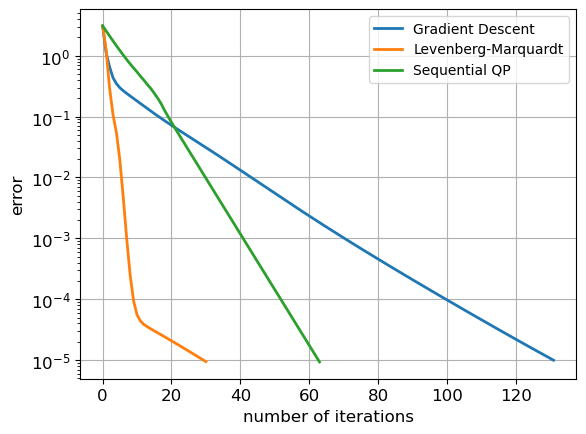

In [ ]:
# Random initial configuration
theta_0 = pin.randomConfiguration(robot.model)

# Method 1: Gradient descent
pin.forwardKinematics(robot.model, robot.data, theta_0)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(theta_0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Run the optimizers
start_time = time.perf_counter_ns()
_, e_gd = ik_gradient_descent(theta_0.copy(), T_D, alpha = 0.45)
end_time = time.perf_counter_ns()
t_gd = end_time - start_time

# Method 2: Levenberg-Marquardt
pin.forwardKinematics(robot.model, robot.data, theta_0)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(theta_0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Run the optimizers
start_time = time.perf_counter_ns()
_, e_lm = ik_Levenberg_Marquardt(theta_0.copy(), T_D, gamma=0.1)
end_time = time.perf_counter_ns()
t_lm = end_time - start_time

# Method 3: Sequential QP
pin.forwardKinematics(robot.model, robot.data, theta_0)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(theta_0)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Run the optimizers
start_time = time.perf_counter_ns()
_, e_sqp = ik_sequential_qp(theta_0.copy(), T_D)
end_time = time.perf_counter_ns()
t_sqp = end_time - start_time

print("\nComputation times of inverse kinematics solvers:")
print(f"    Gradient Descent: {t_gd} ns")
print(f"    Levenberg-Marquardt: {t_lm} ns")
print(f"    Sequential QP: {t_sqp} ns")

# Plot error over iterations
plt.plot(e_gd, linewidth=2, label='Gradient Descent')
plt.plot(e_lm, linewidth=2, label='Levenberg-Marquardt')
plt.plot(e_sqp, linewidth=2, label='Sequential QP')
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid()
plt.show()

Example: Different initial guesses can lead to different final solutions

In the following example, we solve the same inverse kinematic problem using the sequential QP method with 10 different initial guesses. The result will show that different initial guesses generally result in different final solutions, some of which might converge to local minimum.

SUCCESS (in 67 iterations)
SUCCESS (in 64 iterations)
SUCCESS (in 60 iterations)
SUCCESS (in 95 iterations)
SUCCESS (in 65 iterations)
SUCCESS (in 60 iterations)
SUCCESS (in 63 iterations)
SUCCESS (in 74 iterations)
FAILED BUT CONVERGED (  0.0277 in 430 iterations)
SUCCESS (in 62 iterations)


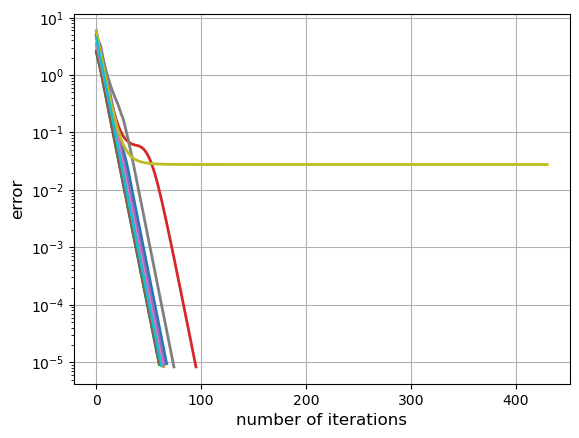

In [ ]:
e_all = []
for i in range(10):
    # Random initial configuration
    theta_0 = pin.randomConfiguration(robot.model)

    # Forward kinematics
    pin.forwardKinematics(robot.model, robot.data, theta_0)
    pin.updateFramePlacements(robot.model, robot.data)

    theta, e = ik_sequential_qp(theta_0.copy(), T_D)
    e_all.append(e)

# Plot error over iterations for all 10 runs
for e in e_all:
    plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.grid()
plt.show()

Example: infeasible problem

When the desired pose is out of reach of the robot arm, the inverse kinematic problem is infeasible. In the following infeasible example, the sequential QP does not converge. 

FAILURE (exceeded 500.0 iterations)


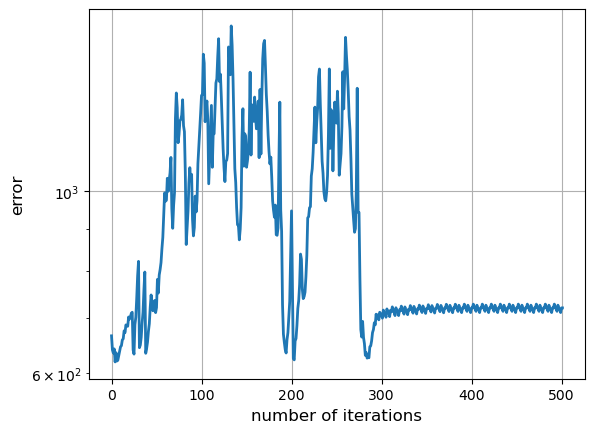

In [ ]:
# Choose an INFEASIBLE desired pose
T_D = np.array([[1., 0., 0., 10.3],
                  [0., -1., 0., 29.4],
                  [0., 0., 1., 17.9],
                  [0., 0., 0., 1.]])

# Show desired pose in the browser window
meshcat_shapes.frame(vis.viewer['frames/' + 'desired_pose'], opacity=1.0, axis_length=0.2)
vis.viewer['frames/' + 'desired_pose'].set_transform(T_D)

# Random initial configuration
theta_0 = pin.randomConfiguration(robot.model)

# Forward kinematics
pin.forwardKinematics(robot.model, robot.data, theta_0)
pin.updateFramePlacements(robot.model, robot.data)

theta, e = ik_sequential_qp(theta_0.copy(), T_D)

# Plot error
plt.plot(e, linewidth=2)
plt.yscale('log')
plt.xlabel('number of iterations', fontsize=12)
plt.ylabel('error', fontsize=12)
plt.grid()
plt.show()